# Pancreas Dataset
- [Tutorial Notebook](https://colab.research.google.com/github/iml-dkfz/nnunet-workshop/blob/master/nnU-Net_Workshop.ipynb#scrollTo=iBxlyQ3rY7X_)
- [Datasets Drive](https://drive.google.com/drive/folders/1HqEgzS8BV2c7xYNrZdEAnrHk7osJJ--2)
- [M3D-CAM w/ nnUNet](https://colab.research.google.com/drive/1b6LMbSM3dvpCS4jEsWVpmgTbsR_rVPUF?usp=sharing)

In [1]:
import os
import shutil
from collections import OrderedDict

import json
import matplotlib.pyplot as plt
import nibabel as nib

import numpy as np
import torch

In [2]:
# check whether GPU accelerated computing is available
assert torch.cuda.is_available() # if there is an error here, enable GPU in the Runtime

In [3]:
import nnunetv2

# Data Preparation

In [85]:
import os
import shutil
import json
import nibabel as nib
import numpy as np

# Define the source directories
source_train = 'RawData/UHN-MedImg3D-ML-quiz/train'
source_val = 'RawData/UHN-MedImg3D-ML-quiz/validation'
source_test = 'RawData/UHN-MedImg3D-ML-quiz/test'

# Define the target directories
target_base = 'RawData'
task_name = 'Task06_PancreasUHN'
target_task_dir = os.path.join(target_base, task_name)
images_tr_dir = os.path.join(target_task_dir, 'imagesTr')
images_ts_dir = os.path.join(target_task_dir, 'imagesTs')
labels_tr_dir = os.path.join(target_task_dir, 'labelsTr')

# Create the target directories if they don't exist
os.makedirs(images_tr_dir, exist_ok=True)
os.makedirs(images_ts_dir, exist_ok=True)
os.makedirs(labels_tr_dir, exist_ok=True)

# Initialize class mapping dictionary
class_mapping = {}

# Function to correct label values
def correct_labels(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()

    print(f"Original unique labels in {file_path}: {np.unique(data)}")

    # Round to nearest valid value
    data_corrected = np.round(data)

    # Explicitly set near values to the exact intended labels
    data_corrected[np.isclose(data_corrected, 0.0)] = 0.0
    data_corrected[np.isclose(data_corrected, 1.0)] = 1.0
    data_corrected[np.isclose(data_corrected, 2.0)] = 2.0

    print(f"Corrected unique labels in {file_path}: {np.unique(data_corrected)}")

    # Save the corrected label file to a temporary path
    temp_file_path = file_path.replace('.nii.gz', '_corrected.nii.gz')
    # corrected_img = nib.Nifti1Image(data_corrected, img.affine, img.header)
    corrected_img = nib.Nifti1Image(data_corrected, img.affine)
    
    nib.save(corrected_img, temp_file_path)
    
    return temp_file_path, np.unique(data_corrected), np.unique(data)

# Function to move files and record class labels
def move_files(source, image_dest, label_dest, class_mapping):
    
    if not label_dest:
        case_id = 0
        total = len(os.listdir(source))
        for file in os.listdir(source):
            if file.endswith('0000.nii.gz'):
                src_image_file = os.path.join(source, file)

                case_str_image = f"case_{case_id:04d}_0000.nii.gz"
                dest_image_file = os.path.join(image_dest, case_str_image)
                shutil.copy(src_image_file, dest_image_file)
                
                print(f"""({case_id}/{total}) Source Image: {src_image_file} 
                      Dest Image: {dest_image_file}
                      Labels: No Class, Not Annotated
                """)
                case_id += 1
            
    else:
        case_id = 0
        for subtype in os.listdir(source):
            subtype_path = os.path.join(source, subtype)
            if os.path.isdir(subtype_path):
                class_id = int(os.path.basename(subtype_path)[-1])
                total = len(os.listdir(subtype_path))
                for file in os.listdir(subtype_path):
                    if file.endswith('0000.nii.gz'):
                        src_image_file = os.path.join(subtype_path, file)

                        case_str_image = f"case_{case_id:04d}_0000.nii.gz"
                        dest_image_file = os.path.join(image_dest, case_str_image)
                        shutil.copy(src_image_file, dest_image_file)

                        src_label_file = src_image_file.replace('_0000.nii.gz', '.nii.gz')
                        
                        # Correct the label file before copying
                        corrected_label_file, unique_labels, orig_labels = correct_labels(src_label_file)
                        # print(corrected_label_file)
                        # print(unique_labels)
                        # print(orig_labels)

                        case_str_label = f"case_{case_id:04d}.nii.gz"
                        dest_label_file = os.path.join(label_dest, case_str_label)
                        
                        shutil.copy(corrected_label_file, dest_label_file)
                        
                        class_mapping[case_str_image] = class_id
                        print(f"""({case_id}/{total}) Source Image: {src_image_file}
                        Source Label: {src_label_file}
                        Corrected Label: {corrected_label_file}
                        
                        Dest Image: {dest_image_file}
                        Dest Label: {dest_label_file}
                        Labels: Class {class_id}, Annotated, Unique labels after correction: {unique_labels}
                        
                        """)
                        case_id += 1
                        # Remove the temporary corrected label file
                        os.remove(corrected_label_file)

# Move training files and record class labels
move_files(source_train, images_tr_dir, labels_tr_dir, class_mapping)
print("\n\n##################\n\n")
move_files(source_val, images_tr_dir, labels_tr_dir, class_mapping)
print("\n\n##################\n\n")
move_files(source_test, images_ts_dir, None, class_mapping)

# Save the class mapping to a JSON file
with open(os.path.join(target_task_dir, 'class_mapping.json'), 'w') as f:
    json.dump(class_mapping, f)

print("Data restructuring complete and class mapping saved.")


Original unique labels in RawData/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416.nii.gz: [0. 1. 2.]
Corrected unique labels in RawData/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416.nii.gz: [0. 1. 2.]
(0/169) Source Image: RawData/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416_0000.nii.gz
                        Source Label: RawData/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416.nii.gz
                        Corrected Label: RawData/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_416_corrected.nii.gz
                        
                        Dest Image: RawData/Task06_PancreasUHN/imagesTr/case_0000_0000.nii.gz
                        Dest Label: RawData/Task06_PancreasUHN/labelsTr/case_0000.nii.gz
                        Labels: Class 2, Annotated, Unique labels after correction: [0. 1. 2.]
                        
                        
Original unique labels in RawData/UHN-MedImg3D-ML-quiz/train/subtype2/quiz_2_040.nii.gz: [0. 1. 2.]
Corrected unique labels in RawData/UHN-MedIm

# Verify Labels

In [18]:
import os
import numpy as np
import nibabel as nib

def load_nifti_image(file_path):
    """Load a NIfTI image and return the data as a numpy array."""
    nifti_image = nib.load(file_path)
    return nifti_image.get_fdata()

def collect_unique_labels(labels_dir):
    """Collect and print all unique labels in the dataset."""
    unique_labels = set()
    
    label_files = sorted(os.listdir(labels_dir))
    
    for lbl_file in label_files:
        lbl_path = os.path.join(labels_dir, lbl_file)
        labels = load_nifti_image(lbl_path)
        unique_labels.update(np.unique(labels))
    
    return unique_labels

In [20]:
# Define the path to the labels directory
t6_labels_dir = 'RawData/Task06_PancreasUHN/labelsTr'

# Collect unique labels
t6_unique_labels = collect_unique_labels(t6_labels_dir)

# Print the unique labels
print(f"Unique labels in the dataset: {sorted(t6_unique_labels)}")


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [24]:
len(t6_unique_labels)

467335

In [36]:
# Define the path to the labels directory
t6_labels_dir = 'RawData/Task06_PancreasUHN/labelsTr'

# Collect unique labels
t6_unique_labels = collect_unique_labels(t6_labels_dir)

# Print the unique labels
print(f"Unique labels in the dataset: {sorted(t6_unique_labels)}")


Unique labels in the dataset: [0.0, 1.0, 1.0000152587890625, 1.9999999995343387, 2.0]


In [69]:
! pwd
! ls RawData/Task06_Pancreas_UHN/imagesTr | wc -l
! ls RawData/Task06_Pancreas_UHN/imagesTs | wc -l

/scratch/alif/nnUNet
252
72


In [70]:
os.environ['RAW_DATA_PATH']

'/scratch/alif/nnUNet/RawData'

# Dataset Building

In [86]:
import os
import json

def create_dataset_json(base_dir, task_name, num_training, num_test):
    
    imagesTr_dir = os.path.join(base_dir, task_name, 'imagesTr')
    labelsTr_dir = os.path.join(base_dir, task_name, 'labelsTr')
    imagesTs_dir = os.path.join(base_dir, task_name, 'imagesTs')

    # Get list of training and test images
    training_images = sorted(os.listdir(imagesTr_dir))
    test_images = sorted(os.listdir(imagesTs_dir))

    # Ensure the number of requested training and test images does not exceed available images
    num_training = min(num_training, len(training_images))
    num_test = min(num_test, len(test_images))

    # Create the dataset dictionary
    dataset = {
        "name": "Pancreas_UHN",
        "description": "Segmentation of pancreatic structures using UHN dataset",
        "tensorImageSize": "3D",
        "reference": "",
        "licence": "",
        "release": "0.0",
        "modality": {
            "0": "CT"
        },
        "labels": {
            "0": "background",
            "1": "pancreas",
            "2": "lesion"
            # Add other structures as needed
        },
        "numTraining": num_training,
        "numTest": num_test,
        "training": [],
        "test": []
    }

    # Populate the training field
    for i in range(num_training):
        dataset['training'].append({
            "image": f"{imagesTr_dir}/{training_images[i]}",
            "label": f"{labelsTr_dir}/{training_images[i].replace('_0000.nii.gz', '.nii.gz')}"
        })

    # Populate the test field
    for i in range(num_test):
        dataset['test'].append(f"{imagesTs_dir}/{test_images[i]}")

    # Save the dataset.json file
    with open(os.path.join(base_dir, task_name, 'dataset.json'), 'w') as f:
        json.dump(dataset, f, indent=4)

# Define the parameters
base_dir = os.environ['RAW_DATA_PATH']
task_name = 'Task06_PancreasUHN'  # Replace 002 with the actual task number
num_training = 252  # Set the number of training samples
num_test = 72  # Set the number of test samples

# Create the dataset.json file
create_dataset_json(base_dir, task_name, num_training, num_test)
print('Done')

Done


In [6]:
import os
def rename_files_with_suffix(images_dir):
    image_files = sorted(os.listdir(images_dir))
    
    for i, img_file in enumerate(image_files):
        # REMOVE SUFFIX FROM DATASET DIR
        new_image_name = img_file.replace('_0000.', '.')
        
        # ADD SUFFIX TO TASK DIR
        # new_image_name = img_file.replace('.nii.gz', '_0000.nii.gz')
        # print(img_file)
        # print(new_image_name)

        os.rename(os.path.join(images_dir, img_file), os.path.join(images_dir, new_image_name))
        
images_dir = '/scratch/alif/nnUNet/nnUNet_raw/Dataset006_PancreasUHN/imagesTr'
# images_dir = '/scratch/alif/nnUNet/RawData/Task06_PancreasUHN/imagesTr'
rename_files_with_suffix(images_dir)

# Convert & Pre-Process

In [87]:
!nnUNetv2_convert_MSD_dataset -i "${RAW_DATA_PATH}/Task06_PancreasUHN"

In [86]:
# ! nnUNet_plan_and_preprocess -t 06 --verify_dataset_integrity

In [118]:
# run this on a CPU node
# !nnUNetv2_plan_and_preprocess -d 6 -np 32

It seems like some of the raw images have been processed as 'label' files, and also the labels aren't perfectly rounded.

In [1]:
# ! export CUDA_LAUNCH_BLOCKING=1
# # ! export TORCH_COMPILE=0
# ! export OMP_NUM_THREADS=1

# # Run the nnUNetv2_train command
# ! CUDA_LAUNCH_BLOCKING=1 nnUNet_n_proc_DA=0 nnUNetv2_train 6 3d_fullres 0 -tr nnUNetTrainer_1epoch

# Run Training

In [4]:
def make_if_dont_exist(folder_path,overwrite=False):
    """
    creates a folder if it does not exists
    input: 
    folder_path : relative path of the folder which needs to be created
    over_write :(default: False) if True overwrite the existing folder 
    """
    if os.path.exists(folder_path):
        
        if not overwrite:
            print(f"{folder_path} exists.")
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
      os.makedirs(folder_path)
      print(f"{folder_path} created!")

# Maybe move path of preprocessed data directly on content - this may be signifcantely faster!
print("Current Working Directory {}".format(os.getcwd()))
path_dict = {
    "nnUNet_raw" : os.path.join(os.getcwd(), "nnUNet_raw"), 
    "nnUNet_preprocessed" : os.path.join(os.getcwd(), "nnUNet_preprocessed"), # 1 experiment: 1 epoch took 112s
    "nnUNet_results" : os.path.join(os.getcwd(), "nnUNet_results"),
    "RAW_DATA_PATH" : os.path.join(os.getcwd(), "RawData"), # This is used here only for convenience (not necessary for nnU-Net)!
}

# Write paths to environment variables
for env_var, path in path_dict.items():
  os.environ[env_var] = path 

# Check whether all environment variables are set correct!
for env_var, path in path_dict.items():
  if os.getenv(env_var) != path:
    print("Error:")
    print("Environment Variable {} is not set correctly!".format(env_var))
    print("Should be {}".format(path))
    print("Variable is {}".format(os.getenv(env_var)))
  make_if_dont_exist(path, overwrite=False)

print("If No Error Occured Continue Forward. =)")

Current Working Directory /scratch/alif/nnUNet
/scratch/alif/nnUNet/nnUNet_raw exists.
/scratch/alif/nnUNet/nnUNet_preprocessed exists.
/scratch/alif/nnUNet/nnUNet_results exists.
/scratch/alif/nnUNet/RawData exists.
If No Error Occured Continue Forward. =)


In [5]:
# os.environ['nnUNet_raw_data_base'] = '/scratch/alif/nnUNet/RawData'
os.environ['nnUNet_raw_data_base'] = '/scratch/alif/nnUNet/nnUNet_raw_data_base'
os.environ['nnUNet_preprocessed'] = '/scratch/alif/nnUNet/nnUNet_preprocessed'
os.environ['RESULTS_FOLDER'] = '/scratch/alif/nnUNet/nnUNet_trained_models'

In [8]:
! ls /scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN/imagesTr/ | head -n 5

case_0000_0000.nii.gz
case_0001_0000.nii.gz
case_0002_0000.nii.gz
case_0003_0000.nii.gz
case_0004_0000.nii.gz


In [7]:
! ls /scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN/labelsTr/ | head -n 5

case_0000.nii.gz
case_0001.nii.gz
case_0002.nii.gz
case_0003.nii.gz
case_0004.nii.gz


In [15]:
# REMOVE SUFFIX FROM DATASET DIR

root_dir = '/scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN'

images_dir = os.path.join(root_dir, 'imagesTr')
image_files = sorted(os.listdir(images_dir))
    
for i, img_file in enumerate(image_files):
    new_image_name = img_file.replace('_0000.', '.')
    os.rename(os.path.join(images_dir, img_file), os.path.join(images_dir, new_image_name))

In [41]:
# ADD SUFFIX TO TASK DIR

root_dir = '/scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task002_Heart'

images_dir = os.path.join(root_dir, 'imagesTs')
image_files = sorted(os.listdir(images_dir))
    
for i, img_file in enumerate(image_files):
    new_image_name = img_file.replace('.nii.gz', '_0000.nii.gz')
    os.rename(os.path.join(images_dir, img_file), os.path.join(images_dir, new_image_name))

In [43]:
! ls /scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN/imagesTr/ | head -n 5

case_0000_0000.nii.gz
case_0001_0000.nii.gz
case_0002_0000.nii.gz
case_0003_0000.nii.gz
case_0004_0000.nii.gz


In [44]:
! ls /scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN/imagesTs/ | head -n 5

case_0000_0000.nii.gz
case_0001_0000.nii.gz
case_0002_0000.nii.gz
case_0003_0000.nii.gz
case_0004_0000.nii.gz


In [45]:
! ls /scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task006_PancreasUHN/labelsTr/ | head -n 5

case_0000.nii.gz
case_0001.nii.gz
case_0002.nii.gz
case_0003.nii.gz
case_0004.nii.gz


In [48]:
import os
import json

def create_dataset_json(base_dir, task_name, num_training, num_test):
    
    imagesTr_dir = os.path.join(base_dir, task_name, 'imagesTr')
    labelsTr_dir = os.path.join(base_dir, task_name, 'labelsTr')
    imagesTs_dir = os.path.join(base_dir, task_name, 'imagesTs')

    # Get list of training and test images
    training_images = sorted(os.listdir(imagesTr_dir))
    test_images = sorted(os.listdir(imagesTs_dir))

    # Ensure the number of requested training and test images does not exceed available images
    num_training = min(num_training, len(training_images))
    num_test = min(num_test, len(test_images))

    # Create the dataset dictionary
    dataset = {
        "name": "Pancreas_UHN",
        "description": "Segmentation of pancreatic structures using UHN dataset",
        "tensorImageSize": "3D",
        "reference": "",
        "licence": "",
        "release": "0.0",
        "modality": {
            "0": "CT"
        },
        "labels": {
            "0": "background",
            "1": "pancreas",
            "2": "lesion"
            # Add other structures as needed
        },
        "numTraining": num_training,
        "numTest": num_test,
        "training": [],
        "test": []
    }

    # Populate the training field
    for i in range(num_training):
        dataset['training'].append({
            # "image": f"{imagesTr_dir}/{training_images[i]}",
            "image": f"./imagesTr/{training_images[i].replace('_0000.nii.gz', '.nii.gz')}",
            "label": f"./labelsTr/{training_images[i].replace('_0000.nii.gz', '.nii.gz')}"
        })

    # Populate the test field
    for i in range(num_test):
        # dataset['test'].append(f"{imagesTs_dir}/{test_images[i]}")
        dataset['test'].append(f"./imagesTs/{test_images[i].replace('_0000.nii.gz', '.nii.gz')}")

    # Save the dataset.json file
    with open(os.path.join(base_dir, task_name, 'dataset.json'), 'w') as f:
        json.dump(dataset, f, indent=4)

# Define the parameters
base_dir = '/scratch/alif/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/'
task_name = 'Task006_PancreasUHN'  # Replace 002 with the actual task number
num_training = 252  # Set the number of training samples
num_test = 72  # Set the number of test samples

# Create the dataset.json file
create_dataset_json(base_dir, task_name, num_training, num_test)
print('Done')

Done


In [49]:
! nnUNet_plan_and_preprocess -t 006 --verify_dataset_integrity



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Verifying training set
checking case case_0000
checking case case_0001
checking case case_0002
checking case case_0003
checking case case_0004
checking case case_0005
checking case case_0006
checking case case_0007
checking case case_0008
checking case case_0009
checking case case_0010
checking case case_0011
checking case case_0012
checking case case_0013
checking case case_0014
checking case case_0015
checking case case_0016
checking case case_0017
checking case case_0018
checking case case_0019
checking case case_0020
checking case case_0021
checking case case_0022
checking case case_0023
checking case case_0024
checking case c

In [50]:
! nnUNet_plan_and_preprocess -t 006



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

case_0000
case_0008
case_0016
case_0024
case_0032
case_0040
case_0048
case_0056
before crop: (1, 49, 109, 161) after crop: (1, 49, 109, 161) spacing: [3.      0.78125 0.78125] 

before crop: (1, 48, 119, 163) after crop: (1, 48, 119, 163) spacing: [3.         0.78710938 0.78710938] 

before crop: (1, 62, 135, 199) after crop: (1, 62, 135, 199) spacing: [2.         0.62109375 0.62109375] 

before crop: (1, 49, 152, 261) after crop: (1, 49, 152, 261) spacing: [3.       0.640625 0.640625] 

before crop: (1, 87, 124, 179) after crop: (1, 87, 124, 179) spacing: [1.5       0.8984375 0.8984375] 

before crop: (1, 117, 115, 194) after cro

In [51]:
! nnUNet_train 3d_fullres nnUNetTrainerV2 Task006_PancreasUHN 0 --npz



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 3d_fullres
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2.nnUNetTrainerV2'>
For that I will be using the following configuration:
num_classes:  2
modalities:  {0: 'CT'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'CT')])
stages...

stage:  0
{'batch_size': 2, 'num_pool_per_axis': [4, 5, 5], 'patch_size': array([ 64, 128, 192]), 'median_patient_size_in_voxels': array([ 59, 117, 181]), 'current_spa

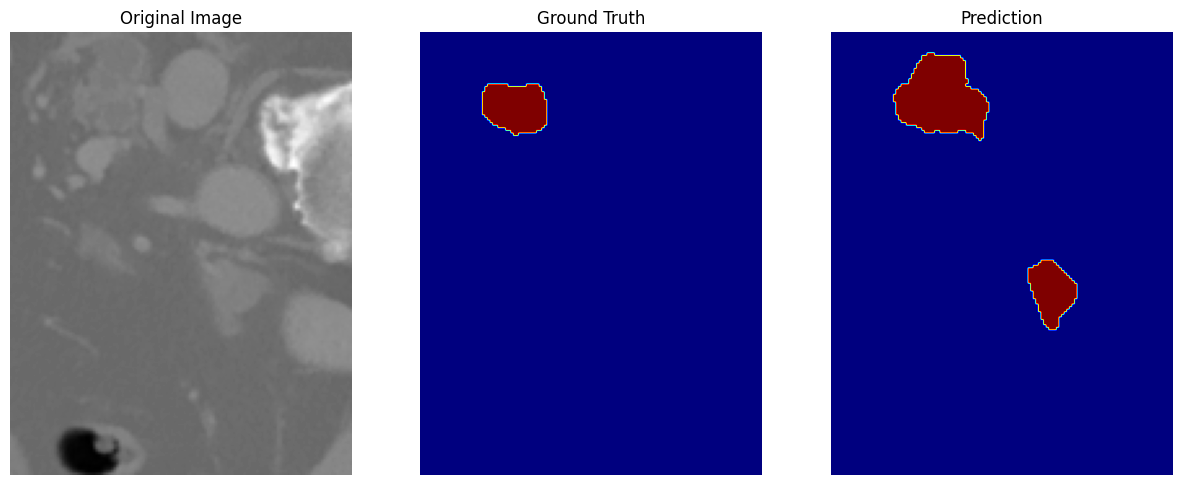

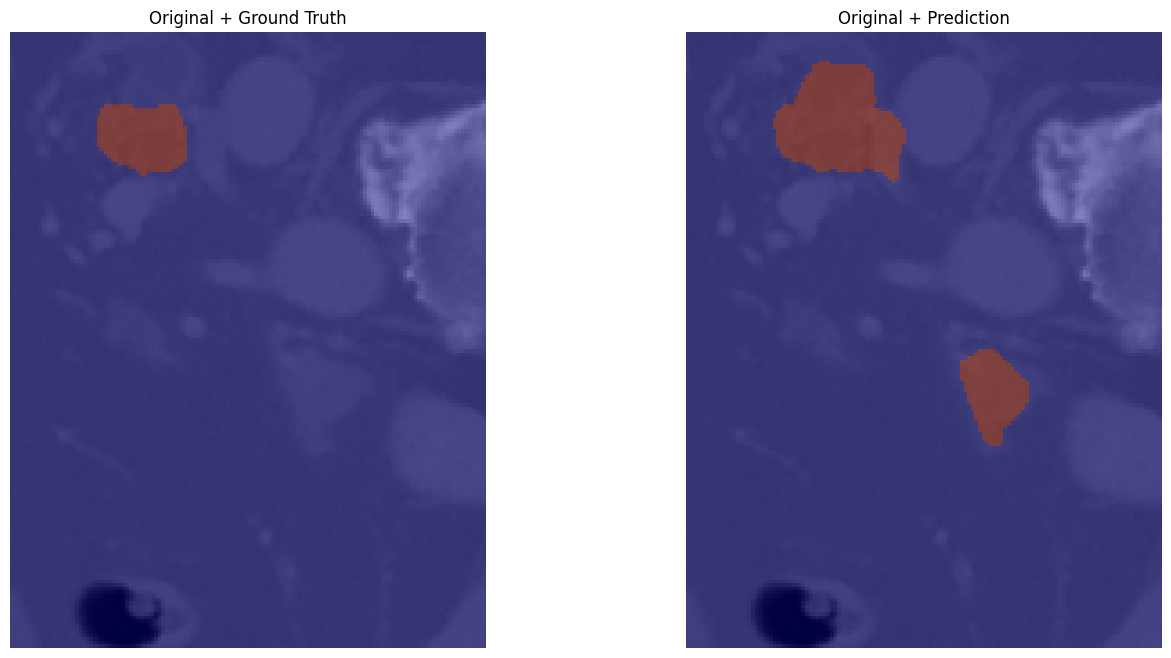

In [16]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def load_nifti_image(file_path):
    """Load a NIfTI image and return the data as a numpy array."""
    nifti_image = nib.load(file_path)
    return nifti_image.get_fdata()

def show_slices(slices, titles=None, cmaps=None):
    """Function to display a row of image slices."""
    fig, axes = plt.subplots(1, len(slices), figsize=(15, 15))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap=cmaps[i] if cmaps else 'gray')
        if titles:
            axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.show()

def show_overlay(image, label, prediction, slice_index, alpha=0.5):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Original + Ground Truth
    axes[0].imshow(image[:, :, slice_index], cmap='gray')
    axes[0].imshow(label[:, :, slice_index], cmap='jet', alpha=alpha)
    axes[0].set_title('Original + Ground Truth')
    axes[0].axis('off')

    # Original + Prediction
    axes[1].imshow(image[:, :, slice_index], cmap='gray')
    axes[1].imshow(prediction[:, :, slice_index], cmap='jet', alpha=alpha)
    axes[1].set_title('Original + Prediction')
    axes[1].axis('off')
    
    plt.show()

# Define paths to the original image and prediction files
original_image_path = '/scratch/alif/nnUNet/nnUNet_raw/Dataset006_PancreasUHN/imagesTr/case_0009_0000.nii.gz'  
label_path = '/scratch/alif/nnUNet/nnUNet_raw/Dataset006_PancreasUHN/labelsTr/case_0009.nii.gz'  
prediction_path = '/scratch/alif/nnUNet/nnUNet_results/Dataset006_PancreasUHN/nnUNetTrainer_1epoch__nnUNetPlans__3d_fullres/fold_0/validation/case_0009.nii.gz'

# Load image and prediction
label = load_nifti_image(label_path)
original_image = load_nifti_image(original_image_path)
prediction = load_nifti_image(prediction_path)

# Select a slice to display
slice_index = original_image.shape[2] // 2

# Display the original image, ground truth label, and prediction side by side
show_slices(
    [original_image[:, :, slice_index], label[:, :, slice_index], prediction[:, :, slice_index]],
    titles=['Original Image', 'Ground Truth', 'Prediction'],
    cmaps=['gray', 'jet', 'jet']
)

# Display overlay of original image with ground truth and prediction
show_overlay(original_image, label, prediction, slice_index)
